In [8]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error

In [9]:
def clean_index(dataframe):
    dataframe.set_index('Unnamed: 0', inplace=True)
    dataframe.index.name = None
    dataframe= dataframe.reset_index(drop=True)
    return dataframe

def add_bms_pred(dataframe, bms_trace, number_param):
    VARS = ['x1',]
    x = dn[[c for c in VARS]].copy()
    y=dataframe.noise

    if number_param==10:
        prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np10.2017-10-18 18:07:35.089658.dat')
    elif number_param==20:
        prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np20.maxs200.2024-05-10 162907.551306.dat')

    #mdl model
    minrow = bms_trace[bms_trace.H == min(bms_trace.H)].iloc[0]
    minH, minexpr, minparvals = minrow.H, minrow.expr, ast.literal_eval(minrow.parvals)

    t = Tree(
        variables=list(x.columns),
        parameters=['a%d' % i for i in range(number_param)],
        x=x, y=y,
        prior_par=prior_par,
        max_size=200,
        from_string=minexpr,
    )

    t.set_par_values(deepcopy(minparvals))

    dplot = deepcopy(dn)
    dplot['ybms'] = t.predict(x)

    return dplot
    
    

In [28]:
#Read NN and BMS data
#n=0;
function='leaky_ReLU' #tanh, leaky_ReLU
realizations=2
N=9
#sigmas=[sigma_y for sigma_y in np.arange(0,0.2,0.02)]
sigmas=[0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20]


runid=0
NPAR=10 #10, 20
steps=50000
train_size=60

rmse_nn_train=[];rmse_nn_test=[]
rmse_mdl_train=[];rmse_mdl_test=[]

mae_nn_train=[];mae_nn_test=[]
mae_mdl_train=[];mae_mdl_test=[]

n_index=[]
r_index=[]
sigma_index=[]

for sigma in sigmas:
    for r in range(realizations+1):
        #Read NN data
        if sigma==0.1:
            file_model='NN_no_overfit_' + function + '_sigma_' + '0.10' + '_r_' + str(r) + '.csv'
        else:
        
            file_model='NN_no_overfit_' + function + '_sigma_' + str(sigma) + '_r_' + str(r) + '.csv'
        model_d='../data/' + file_model
        d=pd.read_csv(model_d)

        for n in range(N+1):
            n_index.append(n)
            r_index.append(r)
            sigma_index.append(sigma)
            dn=d[d['rep']==n]
            dn=clean_index(dn)

            #Read BMS data
            if sigma==0.1:
                filename='BMS_'+function+'_n_'+str(n)+'_sigma_'+'0.10'+ '_r_' + str(r) + '_trace_'+str(steps)+'_prior_'+str(NPAR)+ '.csv'
            else:
                filename='BMS_'+function+'_n_'+str(n)+'_sigma_'+str(sigma)+ '_r_' + str(r) + '_trace_'+str(steps)+'_prior_'+str(NPAR)+ '.csv'
        
        #filename='BMS_'+function+'_n_'+str(n)+'_sigma_'+str(sigma)+'_trace_'+str(steps)+'_prior_'+str(NPAR)+'_id_'+str(runid)+'.csv'
            trace=pd.read_csv('../data/MSTraces/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])
            dplot=add_bms_pred(dn, trace, NPAR)

            #Errors
            rmse_nn_train_i=root_mean_squared_error(dplot.loc[:train_size-1]['ymodel'],dplot.loc[:train_size -1]['y'])
            rmse_nn_train.append(rmse_nn_train_i)
            rmse_nn_test_i=root_mean_squared_error(dplot.loc[train_size-1:]['ymodel'],dplot.loc[train_size -1:]['y'])
            rmse_nn_test.append(rmse_nn_test_i)

            mae_nn_train_i=mean_absolute_error(dplot.loc[:train_size-1]['ymodel'],dplot.loc[:train_size -1]['y'])
            mae_nn_train.append(mae_nn_train_i)
            mae_nn_test_i=mean_absolute_error(dplot.loc[train_size-1:]['ymodel'],dplot.loc[train_size -1:]['y'])
            mae_nn_test.append(mae_nn_test_i)
    
            rmse_mdl_i=mean_squared_error(dplot.ybms,dn.y)
            rmse_mdl_train_i=root_mean_squared_error(dplot.loc[:train_size-1]['ybms'],dn.loc[:train_size-1]['y'])
            rmse_mdl_train.append(rmse_mdl_train_i)
            rmse_mdl_test_i=root_mean_squared_error(dplot.loc[train_size-1:]['ybms'],dn.loc[train_size-1:]['y'])
            rmse_mdl_test.append(rmse_mdl_test_i)

            mae_mdl_train_i=mean_absolute_error(dplot.loc[:train_size-1]['ybms'],dplot.loc[:train_size -1]['y'])
            mae_mdl_train.append(mae_mdl_train_i)
            mae_mdl_test_i=mean_absolute_error(dplot.loc[train_size-1:]['ybms'],dplot.loc[train_size -1:]['y'])
            mae_mdl_test.append(mae_mdl_test_i)

errors_df=pd.DataFrame({'sigma':sigma_index, 'mae_nn_train':mae_nn_train, 'mae_nn_test':mae_nn_test, 'mae_mdl_train':mae_mdl_train, 
                        'mae_mdl_test':mae_mdl_test, 'rmse_nn_train':rmse_nn_train, 'rmse_nn_test': rmse_nn_test, 
                        'rmse_mdl_train':rmse_mdl_train, 'rmse_mdl_test': rmse_mdl_test, 'n':n_index, 'r': r_index})

In [29]:
display(errors_df)

display(errors_df[errors_df['sigma']==0.12])

mean_errors_df=errors_df.groupby(['sigma'],as_index=False)[['mae_nn_train', 'mae_nn_test', 'mae_mdl_train','mae_mdl_test',
                                                            'rmse_nn_train', 'rmse_nn_test', 'rmse_mdl_train','rmse_mdl_test']].mean()
display(mean_errors_df)

std_errors_df=errors_df.groupby(['sigma'],as_index=False)[['mae_nn_train', 'mae_nn_test', 'mae_mdl_train','mae_mdl_test',
                                                           'rmse_nn_train', 'rmse_nn_test', 'rmse_mdl_train','rmse_mdl_test']].std()

std_errors_df=std_errors_df.rename(columns={'mae_nn_train':'mae_nn_train_std', 'mae_nn_test':'mae_nn_test_std', 
                                            'mae_mdl_train':'mae_mdl_train_std','mae_mdl_test':'mae_mdl_test_std',
                                            'rmse_nn_train': 'rmse_nn_train_std', 'rmse_nn_test':'rmse_nn_test_std' , 
                                            'rmse_mdl_train':'rmse_mdl_train_std','rmse_mdl_test':'rmse_mdl_test_std'})

std_errors_df[['mae_nn_train_sdm', 'mae_nn_test_sdm', 'mae_mdl_train_sdm', 'mae_mdl_test_sdm',
               'rmse_nn_train_sdm', 'rmse_nn_test_sdm', 'rmse_mdl_train_sdm', 'rmse_mdl_test_sdm']]=\
std_errors_df[['mae_nn_train_std', 'mae_nn_test_std', 'mae_mdl_train_std', 'mae_mdl_test_std',
               'rmse_nn_train_std', 'rmse_nn_test_std', 'rmse_mdl_train_std', 'rmse_mdl_test_std']]/np.sqrt(N*(realizations+1))
display(std_errors_df)


errors_statistics_df=mean_errors_df.join(std_errors_df.set_index('sigma'), on='sigma')

display(errors_statistics_df)

#save error dataframes
errors_statistics_df.to_csv('../data/'+ 'errors_statistics' + str(function) + '.csv')

,sigma,mae_nn_train,mae_nn_test,mae_mdl_train,mae_mdl_test,rmse_nn_train,rmse_nn_test,rmse_mdl_train,rmse_mdl_test,n,r
0,0.06,0.018732,0.083284,0.022398,0.067949,0.024027,0.090971,0.028203,0.072539,0,0
1,0.06,0.011968,0.244179,0.024748,0.308734,0.015620,0.262822,0.030642,0.327105,1,0
2,0.06,0.026609,0.082431,0.040904,0.279303,0.033940,0.099486,0.045787,0.314320,2,0
3,0.06,0.029613,0.328843,0.010539,0.087249,0.053144,0.337817,0.015333,0.113934,3,0
4,0.06,0.014908,0.054975,0.017585,0.053622,0.017927,0.065063,0.021159,0.062952,4,0
...,...,...,...,...,...,...,...,...,...,...,...
235,0.20,0.074124,0.187386,0.022778,0.125844,0.111458,0.211543,0.024829,0.152622,5,2
236,0.20,0.117989,0.063681,0.126591,0.238867,0.142708,0.068140,0.142359,0.242984,6,2
237,0.20,0.088039,0.255640,0.023182,0.032335,0.124684,0.268635,0.029091,0.038541,7,2
238,0.20,0.127539,0.209643,0.098171,0.143706,0.168219,0.219296,0.114703,0.160794,8,2


,sigma,mae_nn_train,mae_nn_test,mae_mdl_train,mae_mdl_test,rmse_nn_train,rmse_nn_test,rmse_mdl_train,rmse_mdl_test,n,r
90,0.12,0.024105,0.064049,0.026392,0.059776,0.029364,0.069824,0.033791,0.063594,0,0
91,0.12,0.027819,0.215542,0.025033,0.318061,0.034470,0.235767,0.033035,0.335922,1,0
92,0.12,0.033300,0.129659,0.043621,0.264625,0.038090,0.159067,0.049180,0.301438,2,0
93,0.12,0.069332,0.468655,0.058642,0.410887,0.100397,0.478240,0.080193,0.420592,3,0
94,0.12,0.045996,0.170471,0.028619,0.119142,0.058408,0.185553,0.038973,0.121501,4,0
95,0.12,0.034485,0.179752,0.019287,0.167781,0.043346,0.202527,0.021804,0.188699,5,0
96,0.12,0.032384,0.060878,0.047830,0.052848,0.041411,0.069149,0.055138,0.053140,6,0
97,0.12,0.047963,0.224947,0.031236,0.059250,0.063136,0.237980,0.040440,0.078333,7,0
98,0.12,0.053189,0.266779,0.101127,0.162117,0.067625,0.278649,0.113590,0.177441,8,0
99,0.12,0.030545,0.066875,0.041367,0.038006,0.041340,0.079204,0.051557,0.038415,9,0


,sigma,mae_nn_train,mae_nn_test,mae_mdl_train,mae_mdl_test,rmse_nn_train,rmse_nn_test,rmse_mdl_train,rmse_mdl_test
0,0.06,0.022926,0.138846,0.021438,0.393304,0.030396,0.151697,0.026201,0.656841
1,0.08,0.030155,0.133946,0.028633,0.161897,0.039150,0.145990,0.036684,0.180181
2,0.10,0.043011,0.170464,0.039026,0.197208,0.055253,0.185085,0.048659,0.214710
3,0.12,0.090469,0.672278,0.041327,0.174468,0.169040,0.685238,0.050646,0.191976
4,0.14,0.060481,0.250801,0.053748,0.268820,0.082092,0.263700,0.064954,0.284991
5,0.16,0.074424,0.383870,0.056738,0.195993,0.109797,0.400310,0.068208,0.208397
6,0.18,0.072528,0.362814,0.054151,0.267464,0.101848,0.377574,0.067815,0.286291
7,0.20,0.077405,0.174527,0.070661,0.243512,0.102722,0.188062,0.083693,0.258529


,sigma,mae_nn_train_std,mae_nn_test_std,mae_mdl_train_std,mae_mdl_test_std,rmse_nn_train_std,rmse_nn_test_std,rmse_mdl_train_std,rmse_mdl_test_std,mae_nn_train_sdm,mae_nn_test_sdm,mae_mdl_train_sdm,mae_mdl_test_sdm,rmse_nn_train_sdm,rmse_nn_test_sdm,rmse_mdl_train_sdm,rmse_mdl_test_sdm
0,0.06,0.014663,0.086976,0.009031,1.350356,0.020391,0.088170,0.009934,2.679587,0.002822,0.016739,0.001738,0.259876,0.003924,0.016968,0.001912,0.515687
1,0.08,0.013408,0.077703,0.014847,0.128635,0.017032,0.079828,0.019986,0.135553,0.002580,0.014954,0.002857,0.024756,0.003278,0.015363,0.003846,0.026087
2,0.10,0.023206,0.135997,0.021902,0.141163,0.027130,0.137140,0.026403,0.148304,0.004466,0.026173,0.004215,0.027167,0.005221,0.026393,0.005081,0.028541
3,0.12,0.083180,0.725744,0.023430,0.144657,0.192881,0.720500,0.026478,0.167788,0.016008,0.139670,0.004509,0.027839,0.037120,0.138660,0.005096,0.032291
4,0.14,0.036071,0.283822,0.030355,0.130661,0.056115,0.284359,0.034811,0.134604,0.006942,0.054622,0.005842,0.025146,0.010799,0.054725,0.006699,0.025904
5,0.16,0.050950,0.450818,0.036490,0.131344,0.107624,0.451061,0.042382,0.135475,0.009805,0.086760,0.007022,0.025277,0.020712,0.086807,0.008156,0.026072
6,0.18,0.049512,0.432190,0.030026,0.148638,0.088546,0.431265,0.036281,0.154245,0.009529,0.083175,0.005779,0.028605,0.017041,0.082997,0.006982,0.029685
7,0.20,0.031661,0.164236,0.036684,0.126286,0.042746,0.171907,0.041819,0.127100,0.006093,0.031607,0.007060,0.024304,0.008227,0.033084,0.008048,0.024460


,sigma,mae_nn_train,mae_nn_test,mae_mdl_train,mae_mdl_test,rmse_nn_train,rmse_nn_test,rmse_mdl_train,rmse_mdl_test,mae_nn_train_std,...,rmse_mdl_train_std,rmse_mdl_test_std,mae_nn_train_sdm,mae_nn_test_sdm,mae_mdl_train_sdm,mae_mdl_test_sdm,rmse_nn_train_sdm,rmse_nn_test_sdm,rmse_mdl_train_sdm,rmse_mdl_test_sdm
0,0.06,0.022926,0.138846,0.021438,0.393304,0.030396,0.151697,0.026201,0.656841,0.014663,...,0.009934,2.679587,0.002822,0.016739,0.001738,0.259876,0.003924,0.016968,0.001912,0.515687
1,0.08,0.030155,0.133946,0.028633,0.161897,0.039150,0.145990,0.036684,0.180181,0.013408,...,0.019986,0.135553,0.002580,0.014954,0.002857,0.024756,0.003278,0.015363,0.003846,0.026087
2,0.10,0.043011,0.170464,0.039026,0.197208,0.055253,0.185085,0.048659,0.214710,0.023206,...,0.026403,0.148304,0.004466,0.026173,0.004215,0.027167,0.005221,0.026393,0.005081,0.028541
3,0.12,0.090469,0.672278,0.041327,0.174468,0.169040,0.685238,0.050646,0.191976,0.083180,...,0.026478,0.167788,0.016008,0.139670,0.004509,0.027839,0.037120,0.138660,0.005096,0.032291
4,0.14,0.060481,0.250801,0.053748,0.268820,0.082092,0.263700,0.064954,0.284991,0.036071,...,0.034811,0.134604,0.006942,0.054622,0.005842,0.025146,0.010799,0.054725,0.006699,0.025904
5,0.16,0.074424,0.383870,0.056738,0.195993,0.109797,0.400310,0.068208,0.208397,0.050950,...,0.042382,0.135475,0.009805,0.086760,0.007022,0.025277,0.020712,0.086807,0.008156,0.026072
6,0.18,0.072528,0.362814,0.054151,0.267464,0.101848,0.377574,0.067815,0.286291,0.049512,...,0.036281,0.154245,0.009529,0.083175,0.005779,0.028605,0.017041,0.082997,0.006982,0.029685
7,0.20,0.077405,0.174527,0.070661,0.243512,0.102722,0.188062,0.083693,0.258529,0.031661,...,0.041819,0.127100,0.006093,0.031607,0.007060,0.024304,0.008227,0.033084,0.008048,0.024460


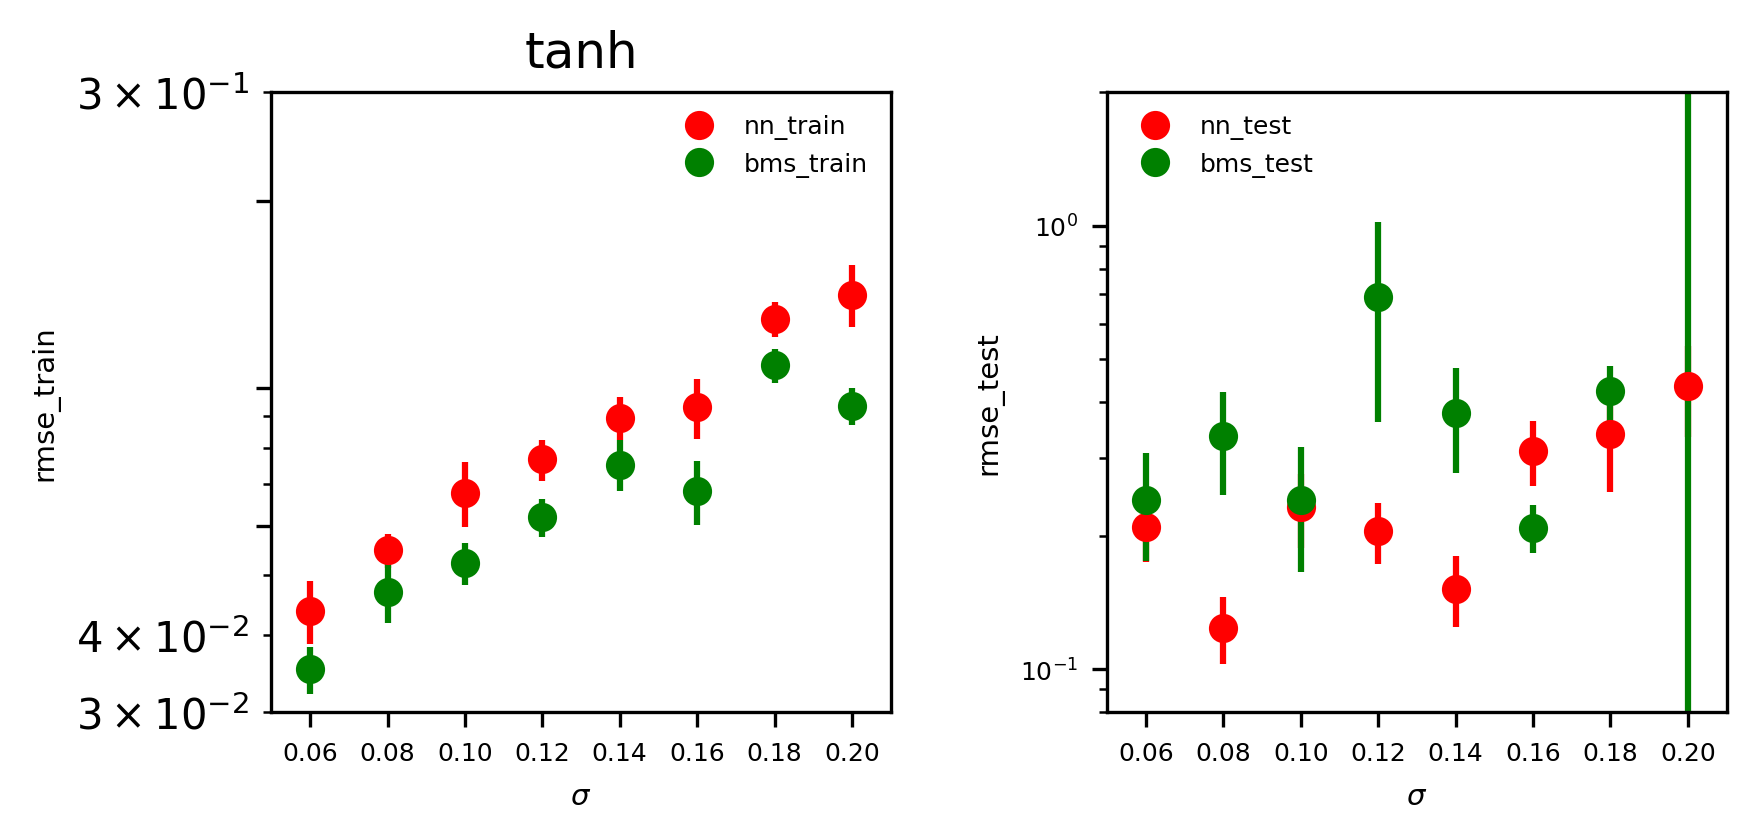

In [6]:
from matplotlib.ticker import NullFormatter
#Plot histogram comparing sigmas
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 14*cm; height=7*cm


Extensions=['.png', '.pdf']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          
m_size=6

fig=figure(figsize=(width,height), dpi=300)  

rows=1;cols=2
gs=gridspec.GridSpec(rows,cols)                                                                                                                                                   
gs.update(left=0.1,right=0.98,bottom=0.15,top=0.90,wspace=0.35,hspace=0.1)     


ax_00=plt.subplot(gs[0,0])  

plt.title(function)
plt.errorbar(errors_statistics_df.sigma, errors_statistics_df.rmse_nn_train, yerr=errors_statistics_df.rmse_nn_train_sdm, marker='o', \
             markersize=m_size, color='red', linestyle='none',label='nn_train')
plt.errorbar(errors_statistics_df.sigma, errors_statistics_df.rmse_mdl_train, yerr=errors_statistics_df.rmse_mdl_train_sdm, marker='o', \
             markersize=m_size, color='green', linestyle='none',label='bms_train')
plt.legend(loc='best',fontsize=size_ticks,frameon=False)
plt.xlabel(r'$\sigma$', fontsize=size_axis)
plt.ylabel('rmse_train', fontsize=size_axis)
plt.xticks(mean_errors_df.sigma,fontsize=size_ticks)
                                                                                                                                                                     
# plt.yticks(yticks_labels, fontsize=size_ticks) 
plt.yscale('log')
plt.ylim(3e-2,0.3)
yticks_labels=[6e-2, 1e-1, 0.2] 
plt.yticks(yticks_labels,fontsize=size_ticks)
ax_00.yaxis.set_major_formatter(NullFormatter())

#ax_00.yaxis.set_major_locator(plt.NullLocator())
#plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6 ,0.7 , 0.8], fontsize=size_ticks)

plt.xlim(0.05, 0.21)



ax_01=plt.subplot(gs[0,1])

plt.errorbar(errors_statistics_df.sigma, errors_statistics_df.rmse_nn_test, yerr=errors_statistics_df.rmse_nn_test_sdm, marker='o', \
             markersize=m_size, color='red', linestyle='none',label='nn_test')
plt.errorbar(errors_statistics_df.sigma, errors_statistics_df.rmse_mdl_test, yerr=errors_statistics_df.rmse_mdl_test_sdm, marker='o', \
             markersize=m_size, color='green', linestyle='none',label='bms_test')

plt.legend(loc='best',fontsize=size_ticks,frameon=False)
plt.xlabel(r'$\sigma$', fontsize=size_axis)
plt.ylabel('rmse_test', fontsize=size_axis)

plt.xticks(mean_errors_df.sigma, fontsize=size_ticks)


plt.yscale('log')
plt.yticks(fontsize=size_ticks)

plt.xlim(0.05, 0.21)

plt.ylim(0.08,2)

output_path='../results/'
name_fig='rmse_first_data_' + str(function) + '_'

plt.savefig(output_path+name_fig+'.svg',dpi=300)

plt.show()

In [58]:
#Plot
train_size_ann=50
validation_border=dn.loc[train_size_ann-1]['x1']
train_border=dn.loc[train_size-1]['x1']

 
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 10*cm; height=8*cm

Extensions=['.png', '.pdf']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          


fig=figure(figsize=(width,height), dpi=300)                                                        


plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color='red', label='ann.  MSE_train= %.2E, MSE_test= %.2E' % ( MSE_nn_train, MSE_nn_test)) 
plt.plot(dplot.x1, dplot.ybms, color='green', linestyle='--',label='mdl.  MSE_train= %.2E, MSE_test= %.2E' % ( MSE_mdl_train, MSE_mdl_test)) 
plt.plot(dn['x1'], dn['y'],'.', markersize=2, color='blue',label='observed') 
plt.plot(dn['x1'], dn['y_noise'],linewidth=line_w, markersize=2, color='orange',label='noise, ' + r'$\sigma$=' + str(sigma) ) 
                                                                                

plt.axvline(x=validation_border,linestyle='--',linewidth=line_w, color='r')
plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')

#plt.title('$%s$' % t.latex(),fontsize=size_title)
plt.title('n=%d, r=%d : $%s$' % (n, realization, t.latex()),fontsize=size_title)
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)

plt.xlim(-2,2);plt.ylim(-0.5,1.5)                                               

Name_figure='Prediction_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)
    
for ext in Extensions:
        plt.savefig('../results/' + Name_figure +ext,dpi=300)

plt.show()

NameError: name 'MSE_nn_train' is not defined

<Figure size 1181.1x944.882 with 0 Axes>